# **Tutorial** - Time Series Prediction of Snow Water Equivalent (SWE) Using LSTM in PyTorch - Now Using UA SWE Data & Hybrid Loss Function


This notebook is a slightly modified version of the protoype model provided to the Frosty Dawgs team, demonstrating an LSTM model to predict SWE on several Huc10 units in Skagit Basin.  It represents the starting point for the team's work and we thank the authors of the original prototype model.  

This notebook modifies the original noebook by chainging the data source to use a longer time series of data (UA data).  Additional modifications include: (1) adds a KGE goodness of fit metric, (2) adds ML Flow tracking capabilities and (3) normalizes the UA data prior to model training. 

First, we import all the necessary libraries such as `torch`, `numpy`, `pandas`, and others for data preprocessing, model building, and evaluation. These libraries are key for handling data, neural networks, and visualization.

In [1]:
import os
import time
import gdown
import torch
import warnings
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as data
from snowML import data_utils as du

from torch import nn
#from tqdm.autonotebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.filterwarnings('ignore')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32

##  Set the MLflow tracking server

Note: Assumes you have already started mlflow by opening a terminal withy mlflow installed and running mlflow uo

In [2]:
# Set our tracking server uri for logging
tracking_uri = "arn:aws:sagemaker:us-west-2:677276086662:mlflow-tracking-server/dawgsML"
mlflow.set_tracking_uri(tracking_uri)

# Create a new MLflow Experiment called "LSTM"
mlflow.set_experiment("ProtoType_Results")

<Experiment: artifact_location='s3://sues-test/199', creation_time=1740199897768, experiment_id='199', last_update_time=1740199897768, lifecycle_stage='active', name='ProtoType_Results', tags={}>

## Data Prepration 

In [3]:
# This function loads the Dawgs model ready data for a given huc number

def get_dogs_data(huc_list, var_list):
    bucket_name = "snowml-model-ready"
    df_dict = {}  # Initialize dictionary
    for huc in huc_list: 
        file_name = f"model_ready_huc{huc}.csv"
        df = du.s3_to_df(file_name, bucket_name)
        df['day'] = pd.to_datetime(df['day'])
        df.set_index('day', inplace=True)  # Set 'day' as the index
        df = df[var_list]
        df_dict[huc] = df  # Store DataFrame in dictionary
    return df_dict


In [4]:
huc_list = [1711000504, 1711000505, 1711000506, 1711000507, 1711000508, 1711000509, 1711000511]
var_list = ["mean_pr", "mean_tair", "mean_swe"]
df_dict = get_dogs_data(huc_list, var_list)
# display an example 
df = df_dict[1711000506]
df.head(2)

,mean_pr,mean_tair,mean_swe
day,,,
1983-10-01,0.0,4.683,0.0
1983-10-02,0.0,5.416,0.0


In [5]:
# This function normalizes the data using the Z-score formula, which helps to standardize the features

def z_score_normalize(df):
    normalized_df = df.copy()

    for column in ["mean_pr", "mean_tair"]:
        column_mean = df[column].mean()
        column_std = df[column].std()
        normalized_df[column] = (df[column] - column_mean) / column_std

    return normalized_df

## **Creating Dataset for Time Series Prediction**

This function transforms time-series data into a format suitable for model training. It uses the lookback parameter to determine how many previous time steps to consider as input features

In [6]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A pandas DataFrame of time series data
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset.iloc[i:(i + lookback), :2].values  # Select first two columns
        target = dataset.iloc[i + lookback, -1:].values  # Selects the last column dynamically
        X.append(feature)
        y.append(target)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [7]:
def train_test_split(data, train_size_fraction):
    train_size_main = int(len(data) * train_size_fraction)
    test_size_main = len(data) - train_size_main
    train_main, test_main = data[:train_size_main], data[train_size_main:]
    return train_main, test_main, train_size_main, test_size_main

## **Snow Model (LSTM Neural Network)**

This is a simple LSTM-based neural network model designed for predicting mean_swe values. The model uses one LSTM layer followed by a linear layer and LeakyReLU activation.



In [8]:
class SnowModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_class, num_layers, dropout):
        super(SnowModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, dropout=self.dropout, batch_first=True)
        self.linear = nn.Linear(hidden_size, num_class)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        device = x.device
        hidden_states = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        cell_states = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm1(x, (hidden_states, cell_states))
        out = self.linear(out[:, -1, :])
        out = self.leaky_relu(out)
        return out

In [9]:
class KGE_Loss(nn.Module):
    def __init__(self, eps=1e-6):
        super(KGE_Loss, self).__init__()
        self.eps = eps  # Small constant for numerical stability

    def forward(self, pred, obs):
        # Ensure tensors are at least 1D
        if pred.ndim == 0 or obs.ndim == 0:
            return torch.tensor(float("nan"), device=pred.device)

        obs_mean = torch.mean(obs)
        pred_mean = torch.mean(pred)

        obs_std = torch.std(obs) + self.eps  # Avoid division by zero
        pred_std = torch.std(pred) + self.eps

        # Compute Pearson correlation manually to avoid `torch.corrcoef` issues
        covariance = torch.mean((pred - pred_mean) * (obs - obs_mean))
        r = covariance / (obs_std * pred_std + self.eps)  # Avoid zero denominator

        # Ensure r is within valid range for correlation (due to numerical errors)
        r = torch.clamp(r, -1 + self.eps, 1 - self.eps)

        alpha = pred_std / obs_std  # Standard deviation ratio
        beta = pred_mean / (obs_mean + self.eps)  # Mean ratio

        # Compute KGE
        kge = 1 - torch.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

        # Ensure loss is finite
        if torch.isnan(kge) or torch.isinf(kge):
            return torch.tensor(float("nan"), device=pred.device)

        return -kge  # Negative KGE for loss minimization


# loss_fn_snotel = KGE_Loss()


In [10]:
class Hybrid_KGE_MSE_Loss(nn.Module):
    def __init__(self, initial_lambda=1.0, final_lambda=1.0, total_epochs=30, eps=1e-6):
        """
        Hybrid loss combining -KGE and MSE.
        :param initial_lambda: Initial weight for MSE loss (higher at the start).
        :param final_lambda: Final weight for MSE loss (lower in later epochs).
        :param total_epochs: Total training epochs for lambda scheduling.
        :param eps: Small constant for numerical stability.
        """
        super(Hybrid_KGE_MSE_Loss, self).__init__()
        self.initial_lambda = initial_lambda
        self.final_lambda = final_lambda
        self.total_epochs = total_epochs
        self.current_epoch = 0
        self.eps = eps
        self.mse_loss = nn.MSELoss()

    def set_epoch(self, epoch):
        """Update lambda dynamically per epoch."""
        self.current_epoch = epoch
        progress = epoch / self.total_epochs
        self.lambda_mse = self.initial_lambda * (1 - progress) + self.final_lambda * progress  # Linear decay

    def forward(self, pred, obs):
        # Ensure tensors are at least 1D
        if pred.ndim == 0 or obs.ndim == 0:
            return torch.tensor(float("nan"), device=pred.device)

        obs_mean = torch.mean(obs)
        pred_mean = torch.mean(pred)

        obs_std = torch.std(obs) + self.eps  # Avoid division by zero
        pred_std = torch.std(pred) + self.eps

        # Compute Pearson correlation manually
        covariance = torch.mean((pred - pred_mean) * (obs - obs_mean))
        r = covariance / (obs_std * pred_std + self.eps)  # Avoid zero denominator

        # Clamp r within [-1, 1] to prevent invalid values
        r = torch.clamp(r, -1 + self.eps, 1 - self.eps)

        alpha = pred_std / obs_std
        beta = pred_mean / (obs_mean + self.eps)

        # Compute KGE
        kge = 1 - torch.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

        # Hybrid loss: -KGE + lambda * MSE
        mse = self.mse_loss(pred, obs)
        hybrid_loss = -kge + self.lambda_mse * mse

        return hybrid_loss


## **Training the Model**

This function trains the model on the training data for a specified number of epochs and batch size. 

In [11]:
def train_model(model, optimizer, loss_fn, X_train, y_train, n_epochs, batch_size):
    loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)
    epoch_losses = []

    for epoch in  range(n_epochs):
        epoch_loss = 0.0
        loss_fn.set_epoch(epoch)
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        # Validation
        #if epoch % 10 != 0:
            #continue

        model.eval()

        with torch.no_grad():
            y_pred = model(X_train)
            train_loss = loss_fn(y_pred, y_train)
            print(f"Epoch {epoch}: train loss {train_loss:.4f}")

        epoch_losses.append(epoch_loss / len(loader))

    return epoch_losses

## **Predicting and Plotting Results**

This function predicts values on the training and test datasets and visualizes the predictions compared to the actual mean_swe values.



In [12]:
def predict(data, model, X_train,X_test, lookback, train_size, huc_no):
    data = data.astype(object)
    with torch.no_grad():
        train_plot = np.full_like(data['mean_swe'].values, np.nan, dtype=float)
        y_pred = model(X_train)
        print(y_pred.shape)
        y_pred_new = y_pred[:,  -1].unsqueeze(1)
        print(y_pred_new.shape)
        print(type(lookback),type(train_size))
        train_plot[lookback:train_size] = y_pred_new.numpy().flatten()

        # shift test predictions for plotting
        test_plot = np.full_like(data['mean_swe'].values, np.nan, dtype=float)
        test_plot[train_size+lookback:len(data)] = model(X_test)[:,  -1].unsqueeze(1).numpy().flatten()

    # plot
    fig, ax = plt.subplots(figsize=(12, 6))  # Create figure explicitly
    ax.plot(data.index, data['mean_swe'], c='b', label='Actual')
    ax.plot(data.index, train_plot, c='r', label='Train Predictions')
    ax.plot(data.index[train_size+lookback:], test_plot[train_size+lookback:], c='g', label='Test Predictions')
    ax.legend()
    ax.set_xlabel('Date')
    ax.set_ylabel('mean_swe')
    ttl = f"UAData_SWE_Post_Predictions_for_huc_{huc_no}"
    ax.set_title(ttl)
    plt.show()

    fig.savefig(f"{ttl}.png", bbox_inches='tight')
    mlflow.log_artifact(f"swe_plots/{ttl}.png")
    plt.close(fig)

## **Model Evaluation**
This function evaluates the model using standard metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared score (R2). In addition, Kling-gupta-efficiency (KGE) added by the Frosty Dawgs team. 

In [13]:
def kling_gupta_efficiency(y_true, y_pred):
    r = np.corrcoef(y_true.ravel(), y_pred.ravel())[0, 1] # Correlation coefficient
    alpha = np.std(y_pred) / np.std(y_true)  # Variability ratio
    beta = np.mean(y_pred) / np.mean(y_true)  # Bias ratio
    kge = 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    #print(f"r: {r}, alpha: {alpha}, beta: {beta}")
    return kge

In [14]:
def evaluate_metrics(model, X_train, y_train, X_test, y_test):
    with torch.no_grad():
        y_train_pred = model(X_train)
        y_test_pred = model(X_test)

    train_mse = mean_squared_error(y_train.numpy(), y_train_pred.numpy())
    test_mse = mean_squared_error(y_test.numpy(), y_test_pred.numpy())
    train_mae = mean_absolute_error(y_train.numpy(), y_train_pred.numpy())
    test_mae = mean_absolute_error(y_test.numpy(), y_test_pred.numpy())
    train_r2 = r2_score(y_train.numpy(), y_train_pred.numpy())
    test_r2 = r2_score(y_test.numpy(), y_test_pred.numpy())

    test_kge = kling_gupta_efficiency(y_test.numpy(), y_test_pred.numpy())  
    train_kge = kling_gupta_efficiency(y_train.numpy(), y_train_pred.numpy())  

    return [train_mse, test_mse, train_mae, test_mae, train_r2, test_r2, train_kge, test_kge]


In [15]:
def  get_csv_filenames(directory):
  """ Returns a sorted list of CSV filenames from the given directory."""
  return  sorted([f for f in os.listdir(directory)  if f.endswith('.csv')])

## **Running the Pipeline**

This section retrieves the filenames from the dataset directories, filters and merges data, and finally trains and evaluates the model.

NA datais mean_pr      0
mean_tair    0
mean_swe     0
dtype: int64

Lookback: 180
Epoch 0: train loss -0.2082
Epoch 1: train loss -0.2924
Epoch 2: train loss -0.7748
Epoch 3: train loss -0.6482
Epoch 4: train loss -0.8513
Epoch 5: train loss -0.9185
Epoch 6: train loss -0.9320
Epoch 7: train loss -0.8489
Epoch 8: train loss -0.9130
Epoch 9: train loss -0.9180
Epoch 10: train loss -0.8550
Epoch 11: train loss -0.8040
Epoch 12: train loss -0.7828
Epoch 13: train loss -0.7634
Epoch 14: train loss -0.9065
Epoch 15: train loss -0.9183
Epoch 16: train loss -0.8310
Epoch 17: train loss -0.9541
Epoch 18: train loss -0.7439
Epoch 19: train loss -0.9608
torch.Size([9363, 1])
torch.Size([9363, 1])
<class 'int'> <class 'int'>


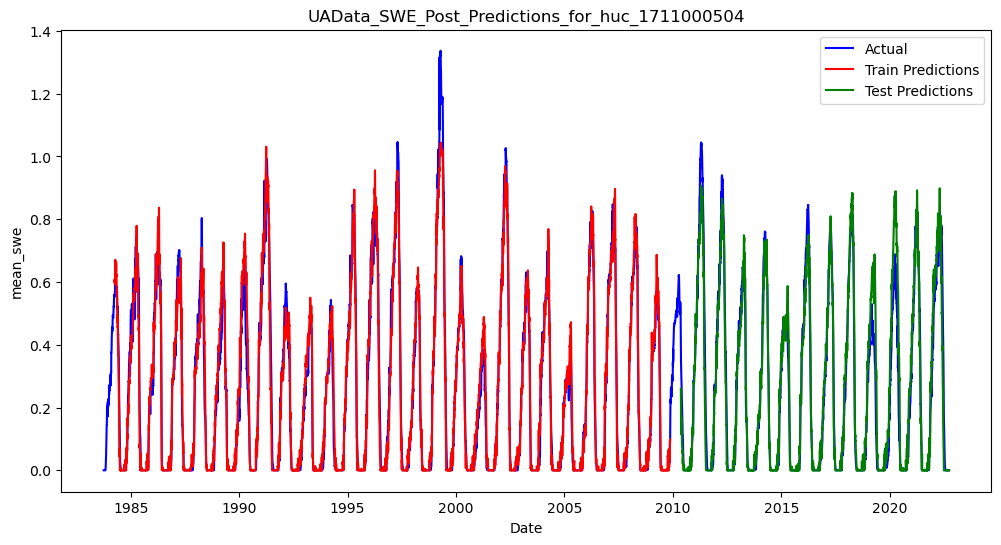

[0.0028946535, 0.0050641918, 0.034769204, 0.043591995, 0.9630914330482483, 0.9362388253211975, 0.9637760869476023, 0.9532561244673415]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180      UA  train_mse  0.002895       307.90096
1       180      UA   test_mse  0.005064       307.90096
2       180      UA  train_mae  0.034769       307.90096
3       180      UA   test_mae  0.043592       307.90096
4       180      UA   train_r2  0.963091       307.90096
5       180      UA    test_r2  0.936239       307.90096
6       180      UA  train_kge  0.963776       307.90096
7       180      UA   test_kge  0.953256       307.90096
NA datais mean_pr      0
mean_tair    0
mean_swe     0
dtype: int64

Lookback: 180
Epoch 0: train loss -0.8883
Epoch 1: train loss -0.9235
Epoch 2: train loss -0.9490
Epoch 3: train loss -0.9775
Epoch 4: train loss -0.8770
Epoch 5: train loss -0.8924
Epoch 6: train loss -0.9838
Epoch 7: train loss -0.9455
Epoch 8: train loss -0.9621
Epoch 9: train lo

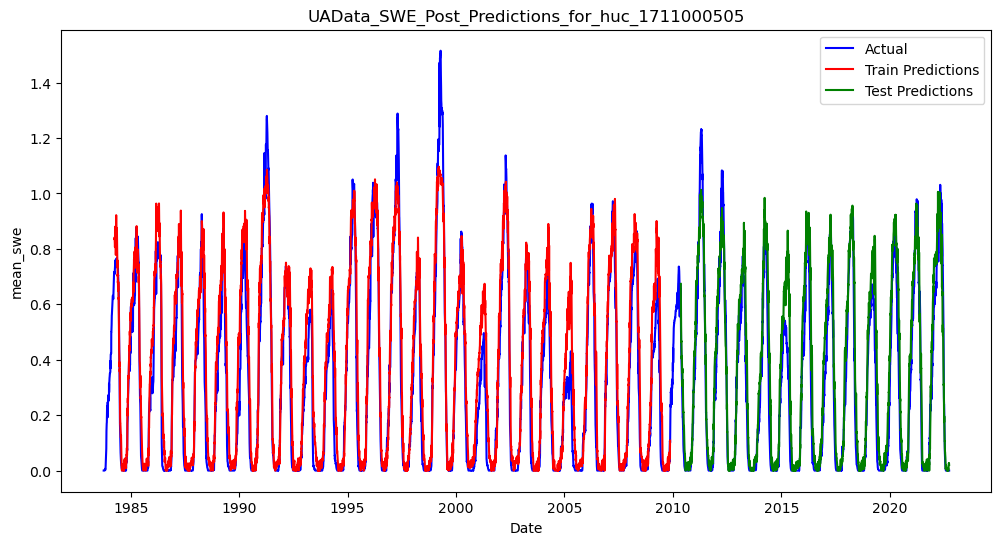

[0.012080964, 0.0115147615, 0.079081, 0.076542355, 0.8924078345298767, 0.8903418779373169, 0.8035262603750117, 0.8099715571157957]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180      UA  train_mse  0.012081       299.47437
1       180      UA   test_mse  0.011515       299.47437
2       180      UA  train_mae  0.079081       299.47437
3       180      UA   test_mae  0.076542       299.47437
4       180      UA   train_r2  0.892408       299.47437
5       180      UA    test_r2  0.890342       299.47437
6       180      UA  train_kge  0.803526       299.47437
7       180      UA   test_kge  0.809972       299.47437
NA datais mean_pr      0
mean_tair    0
mean_swe     0
dtype: int64

Lookback: 180
Epoch 0: train loss -0.9127
Epoch 1: train loss -0.9356
Epoch 2: train loss -0.9399
Epoch 3: train loss -0.8966
Epoch 4: train loss -0.9288
Epoch 5: train loss -0.9505
Epoch 6: train loss -0.8952
Epoch 7: train loss -0.9479
Epoch 8: train loss -0.9635
Epoch 9: train loss -

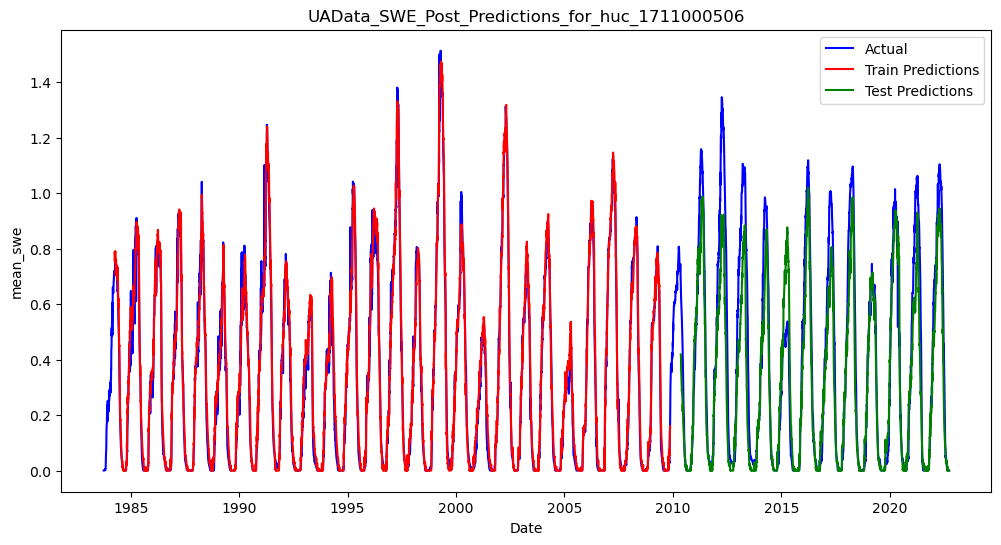

[0.0018240735, 0.020588227, 0.030915555, 0.093650155, 0.9839057326316833, 0.8572501540184021, 0.9611839108341895, 0.7531023498171773]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180      UA  train_mse  0.001824      307.728476
1       180      UA   test_mse  0.020588      307.728476
2       180      UA  train_mae  0.030916      307.728476
3       180      UA   test_mae  0.093650      307.728476
4       180      UA   train_r2  0.983906      307.728476
5       180      UA    test_r2  0.857250      307.728476
6       180      UA  train_kge  0.961184      307.728476
7       180      UA   test_kge  0.753102      307.728476
NA datais mean_pr      0
mean_tair    0
mean_swe     0
dtype: int64

Lookback: 180
Epoch 0: train loss -0.9847
Epoch 1: train loss -0.9860
Epoch 2: train loss -0.9151
Epoch 3: train loss -0.9482
Epoch 4: train loss -0.9802
Epoch 5: train loss -0.9535
Epoch 6: train loss -0.9789
Epoch 7: train loss -0.9813
Epoch 8: train loss -0.9627
Epoch 9: train los

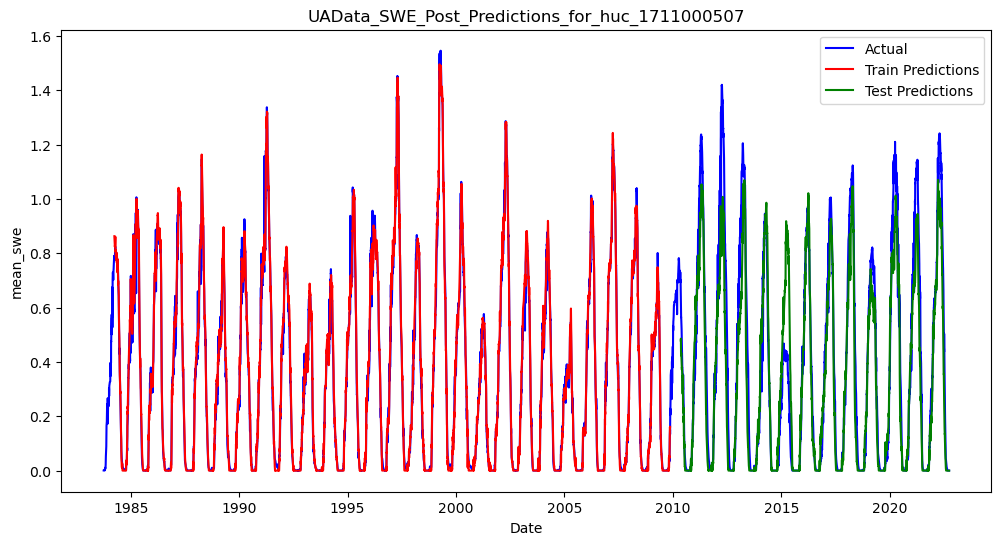

[0.00091200037, 0.018665167, 0.020181939, 0.08734493, 0.9923558831214905, 0.8757550120353699, 0.9769126750098932, 0.8223087410701998]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180      UA  train_mse  0.000912      329.420873
1       180      UA   test_mse  0.018665      329.420873
2       180      UA  train_mae  0.020182      329.420873
3       180      UA   test_mae  0.087345      329.420873
4       180      UA   train_r2  0.992356      329.420873
5       180      UA    test_r2  0.875755      329.420873
6       180      UA  train_kge  0.976913      329.420873
7       180      UA   test_kge  0.822309      329.420873
NA datais mean_pr      0
mean_tair    0
mean_swe     0
dtype: int64

Lookback: 180
Epoch 0: train loss -0.9644
Epoch 1: train loss -0.9666
Epoch 2: train loss -0.9952
Epoch 3: train loss -0.9635
Epoch 4: train loss -0.9851
Epoch 5: train loss -0.9828
Epoch 6: train loss -0.9913
Epoch 7: train loss -0.9852
Epoch 8: train loss -0.9785
Epoch 9: train los

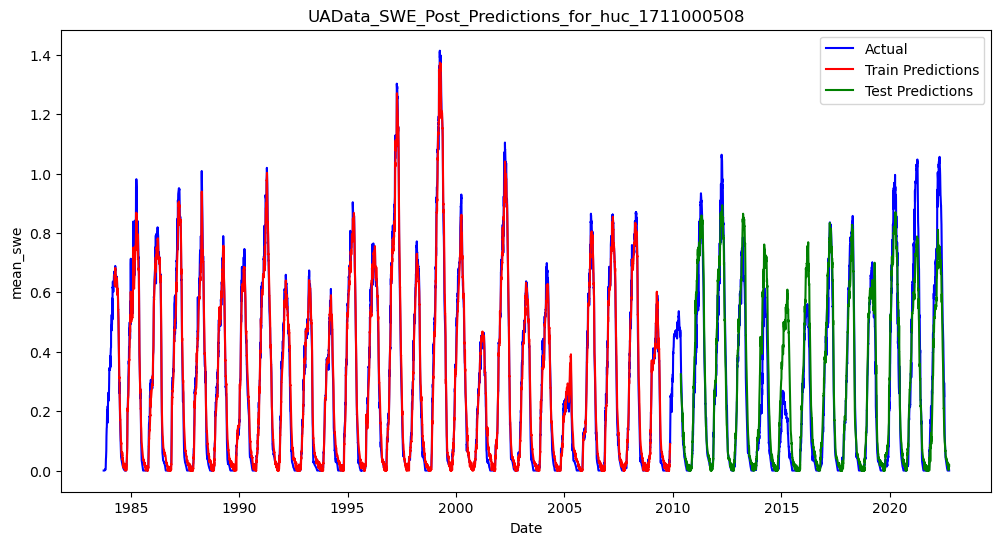

[0.0012153268, 0.0101954695, 0.02704077, 0.06649766, 0.9871547818183899, 0.8873434662818909, 0.9511997721637931, 0.8815767590908563]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180      UA  train_mse  0.001215      304.986027
1       180      UA   test_mse  0.010195      304.986027
2       180      UA  train_mae  0.027041      304.986027
3       180      UA   test_mae  0.066498      304.986027
4       180      UA   train_r2  0.987155      304.986027
5       180      UA    test_r2  0.887343      304.986027
6       180      UA  train_kge  0.951200      304.986027
7       180      UA   test_kge  0.881577      304.986027
NA datais mean_pr      0
mean_tair    0
mean_swe     0
dtype: int64

Lookback: 180
Epoch 0: train loss -0.9751
Epoch 1: train loss -0.9619
Epoch 2: train loss -0.9396
Epoch 3: train loss -0.9408
Epoch 4: train loss -0.9865
Epoch 5: train loss -0.9766
Epoch 6: train loss -0.9350
Epoch 7: train loss -0.9823
Epoch 8: train loss -0.9756
Epoch 9: train loss

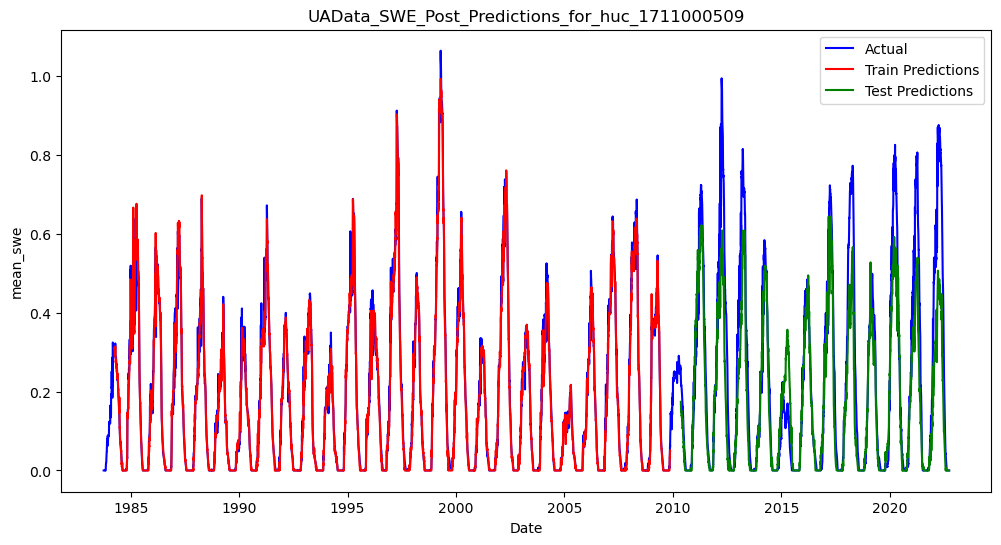

[0.00031009497, 0.013468633, 0.010766857, 0.071648255, 0.9919446110725403, 0.7898238301277161, 0.9884347358043983, 0.6509729265977436]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180      UA  train_mse  0.000310      302.423241
1       180      UA   test_mse  0.013469      302.423241
2       180      UA  train_mae  0.010767      302.423241
3       180      UA   test_mae  0.071648      302.423241
4       180      UA   train_r2  0.991945      302.423241
5       180      UA    test_r2  0.789824      302.423241
6       180      UA  train_kge  0.988435      302.423241
7       180      UA   test_kge  0.650973      302.423241
NA datais mean_pr      0
mean_tair    0
mean_swe     0
dtype: int64

Lookback: 180
Epoch 0: train loss -0.9646
Epoch 1: train loss -0.9884
Epoch 2: train loss -0.9521
Epoch 3: train loss -0.9276
Epoch 4: train loss -0.9846
Epoch 5: train loss -0.4494
Epoch 6: train loss -0.8917
Epoch 7: train loss -0.8954
Epoch 8: train loss -0.9187
Epoch 9: train lo

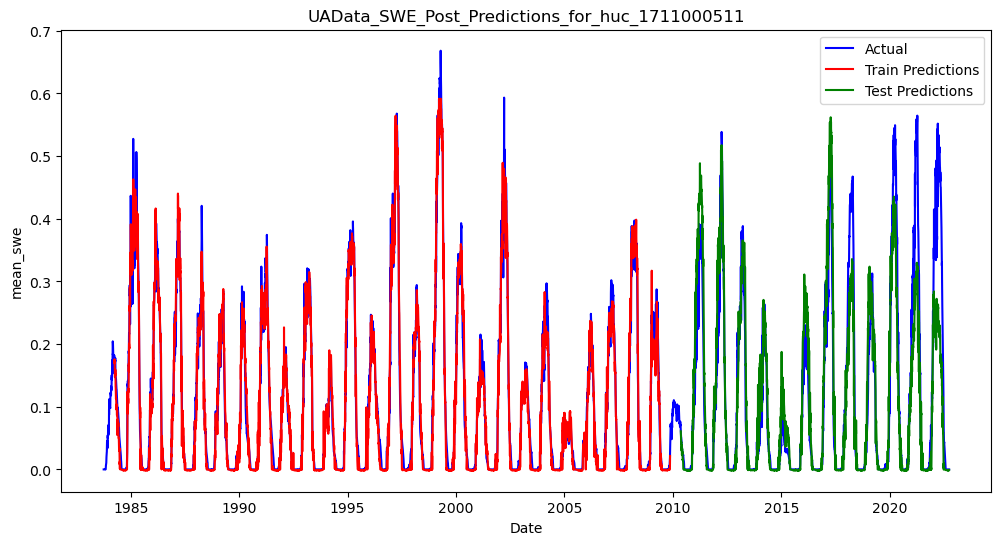

[0.00044315477, 0.00445858, 0.014000262, 0.03854856, 0.9733978509902954, 0.8037219047546387, 0.9714124001160517, 0.8544557259682236]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180      UA  train_mse  0.000443      297.380124
1       180      UA   test_mse  0.004459      297.380124
2       180      UA  train_mae  0.014000      297.380124
3       180      UA   test_mae  0.038549      297.380124
4       180      UA   train_r2  0.973398      297.380124
5       180      UA    test_r2  0.803722      297.380124
6       180      UA  train_kge  0.971412      297.380124
7       180      UA   test_kge  0.854456      297.380124
🏃 View run omniscient-crow-491 at: https://us-west-2.experiments.sagemaker.aws/#/experiments/199/runs/70a435b6d9434ac29254b9ff21d14983
🧪 View experiment at: https://us-west-2.experiments.sagemaker.aws/#/experiments/199


In [16]:
# Define the hyperparameters
input_size=2
hidden_size=2**6
num_class=1
num_layers=1
dropout = 0.5

learning_rate = 1e-3 #3e-3
n_epochs = 20
train_size_fraction = 0.67
lookback_values =  [180]


with mlflow.start_run():
    # log all the params
    mlflow.log_param("Training From", "Prototype Notebook")
    mlflow.log_param("Data Source", "UA SWE Data")
    mlflow.log_param("input_size", input_size)
    mlflow.log_param("hidden_size", hidden_size)
    mlflow.log_param("num_class", num_class)
    mlflow.log_param("num_layers", num_layers)
    mlflow.log_param("dropout", dropout)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("train_size_fraction", train_size_fraction)
    mlflow.log_param("lookback_values", lookback_values)
    mlflow.log_param("epochs", n_epochs) 
    

    model_snotel = SnowModel(input_size, hidden_size, num_class, num_layers, dropout)
    optimizer_snotel = optim.Adam(model_snotel.parameters())
    #loss_fn_snotel = nn.MSELoss()
    #loss_fn_snotel = KGE_Loss()
    loss_fn_snotel = Hybrid_KGE_MSE_Loss(initial_lambda=1.0, final_lambda=1.0, total_epochs=n_epochs)
    mlflow.log_param("loss_function", loss_fn_snotel)
    

    for huc_no in huc_list: 
        # Get the model ready data 
        data = df_dict[(huc_no)]
        data = z_score_normalize(data)
        print(f"NA datais {data.isna().sum()}")
        data = data.fillna(method='bfill')
        train_main, test_main, train_size_main, test_size_main = train_test_split(data, train_size_fraction)

        # Usage example
        lookback_values =  [180]
        results = []

        for lookback in lookback_values:
            print(f"\nLookback: {lookback}")
            start_time = time.time()

            # Snotel dataset
            X_train_snotel, y_train_snotel = create_dataset(train_main, lookback)
            X_test_snotel, y_test_snotel = create_dataset(test_main, lookback)

            train_model(model_snotel, optimizer_snotel, loss_fn_snotel, X_train_snotel, y_train_snotel, n_epochs=n_epochs, batch_size=8) 
            predict(data,model_snotel,  X_train_snotel,X_test_snotel, lookback, train_size_main, huc_no)
            snotel_metrics = evaluate_metrics(model_snotel, X_train_snotel, y_train_snotel, X_test_snotel, y_test_snotel)
            print(snotel_metrics)
            elapsed_time = time.time() - start_time

            results.append([lookback, 'UA', 'train_mse', snotel_metrics[0], elapsed_time])
            results.append([lookback, 'UA', 'test_mse', snotel_metrics[1], elapsed_time])
            results.append([lookback, 'UA', 'train_mae', snotel_metrics[2], elapsed_time])
            results.append([lookback, 'UA', 'test_mae', snotel_metrics[3], elapsed_time])
            results.append([lookback, 'UA', 'train_r2', snotel_metrics[4], elapsed_time])
            results.append([lookback, 'UA', 'test_r2', snotel_metrics[5], elapsed_time])
            results.append([lookback, 'UA', 'train_kge', snotel_metrics[6], elapsed_time])
            results.append([lookback, 'UA', 'test_kge', snotel_metrics[7], elapsed_time])

            
            mlflow.log_metric(f"{huc_no}_train_mse", snotel_metrics[0])
            mlflow.log_metric(f"{huc_no}_test_mse", snotel_metrics[1])
            mlflow.log_metric(f"{huc_no}_train_kge", snotel_metrics[6])
            mlflow.log_metric(f"{huc_no}_test_kge", snotel_metrics[7])

        


        # Create a DataFrame for the results
        df_results = pd.DataFrame(results, columns=['Lookback', 'Dataset', 'Metric', 'Value', 'Time Taken (s)'])

        # Print the DataFrame
        print(df_results)